In [100]:
!pip install osmnx
!pip install pandas
!pip install folium
!pip install scikit-learn

In [101]:
import osmnx as ox
import pandas as pd
import folium
from sklearn.cluster import KMeans
from folium.plugins import HeatMap
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import unary_union

/var/folders/vz/b1smgzt13_dbs5c1rbj4m3dh0000gn/T/ipykernel_55740/446982971.py:15: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bus_stops = ox.geometries_from_place(place_name, tags=tags_bus)


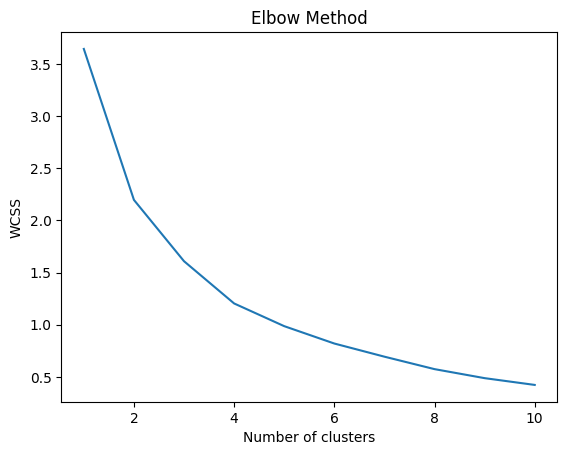

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [102]:
def is_bike_friendly(edge):
    bike_friendly_tags = ['yes', 'designated', 'permissive', 'lane', 'shared', 'shared_lane']
    bike_path_types = ['cycleway', 'path', 'living_street', 'residential']
    is_bike_tag_friendly = edge.get('bicycle') in bike_friendly_tags
    is_highway_type_friendly = edge.get('highway') in bike_path_types
    has_cycleway_infrastructure = ('cycleway' in edge) or ('cycleway:right' in edge) or ('cycleway:left' in edge)
    is_footway_bike_friendly = (edge.get('highway') in ['footway', 'pedestrian']) and edge.get('bicycle') == 'yes'
    return is_bike_tag_friendly or is_highway_type_friendly or has_cycleway_infrastructure or is_footway_bike_friendly

place_name = "Münster, Germany"
G = ox.graph_from_place(place_name, network_type='all')
df = pd.read_csv('filtered_data_munster.csv')

tags_bus = {'highway': 'bus_stop'}
bus_stops = ox.geometries_from_place(place_name, tags=tags_bus)

edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
bike_friendly_edges = edges[edges.apply(is_bike_friendly, axis=1)]

crs_proj = 'EPSG:32632'
bus_stops = bus_stops.to_crs(crs_proj)
bike_friendly_edges = bike_friendly_edges.to_crs(crs_proj)
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False).to_crs(crs_proj)

bus_stops_buffer = bus_stops.buffer(20)
bike_friendly_buffer = bike_friendly_edges.buffer(20)

near_bus_stops = nodes[nodes.geometry.apply(lambda x: bus_stops_buffer.contains(x).any())]
near_bike_paths = nodes[nodes.geometry.apply(lambda x: bike_friendly_buffer.contains(x).any())]
near_both = near_bus_stops[near_bus_stops.index.isin(near_bike_paths.index)].to_crs('EPSG:4326')

df_near_both_coords = pd.DataFrame([(point.x, point.y) for point in near_both.geometry], columns=['Longitude', 'Latitude'])

# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_near_both_coords[['Longitude', 'Latitude']])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Select number of clusters based on Elbow Method
num_clusters = 1  # Set based on Elbow plot result

# K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(df_near_both_coords[['Longitude', 'Latitude']])
near_both['Cluster'] = clusters

cluster_info = near_both.groupby('Cluster').agg({'geometry': 'count'}).rename(columns={'geometry': 'Count'})
max_count = cluster_info['Count'].max()
cluster_info['Normalized_Count'] = cluster_info['Count'] / max_count

map = folium.Map(location=[51.9625, 7.6256], zoom_start=13)

# Cluster visualization with interactive popups
for cluster_id, row in cluster_info.iterrows():
    cluster_center = kmeans.cluster_centers_[cluster_id]
    popup_text = f"Cluster: {cluster_id}\nCount: {row['Count']}"
    color = plt.cm.Reds(row['Normalized_Count'])
    color_hex = matplotlib.colors.to_hex(color)
    folium.Circle(
        location=[cluster_center[1], cluster_center[0]],
        radius=10 + row['Count'] * 2,
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.6,
        popup=popup_text
    ).add_to(map)

# Accident points visualization
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='blue',
        fill=True
    ).add_to(map)

# Adding a HeatMap layer
heat_data = [[row['Latitude'], row['Longitude']] for _, row in df.iterrows()]
HeatMap(heat_data).add_to(map)

# Save and display the map
map.save('kmeans_zones_munster.html')
map

In [103]:
!pip install geopy

In [104]:
from geopy.distance import geodesic

# Define the center and radius of the first cluster's circle
cluster_id = 0  # First cluster
cluster_center = kmeans.cluster_centers_[cluster_id]
radius = 10 + cluster_info.loc[cluster_id, 'Count'] * 2  # meters

# Function to check if a point is within the circle
def is_within_circle(point, center, radius):
    distance = geodesic((center[1], center[0]), (point.y, point.x)).meters
    return distance <= radius

# Filter near_both points for those within the first cluster's circle
first_cluster_circle_points = near_both[near_both.apply(lambda x: is_within_circle(x.geometry, cluster_center, radius), axis=1)]

# Clear previous points from the map if needed
map = folium.Map(location=[51.9625, 7.6256], zoom_start=13)

# Plot only those points within the first cluster's circle
for _, row in first_cluster_circle_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7
    ).add_to(map)

# Save and display the map
map.save('first_cluster_circle_points_only.html')
map


In [105]:
# Extract coordinates for clustering
coordinates = first_cluster_circle_points[['geometry']].apply(lambda row: [row.geometry.x, row.geometry.y], axis=1).tolist()

# New K-Means clustering
kmeans_new = KMeans(n_clusters=2, random_state=0)  # Adjust the number of clusters as needed
new_clusters = kmeans_new.fit_predict(coordinates)

# Add the new cluster labels to the DataFrame
first_cluster_circle_points['New_Cluster'] = new_clusters
# Plot the new cluster centers
for center in kmeans_new.cluster_centers_:
    folium.Marker(
        location=[center[1], center[0]],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map)

# Plot the new cluster points
for _, row in first_cluster_circle_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='blue' if row['New_Cluster'] == 0 else 'purple',  # Different color for each cluster
        fill=True,
        fill_color='blue' if row['New_Cluster'] == 0 else 'purple',
        fill_opacity=0.7
    ).add_to(map)

# Save and display the map
map.save('new_clusters_within_first_cluster.html')
map


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [108]:
import folium
from sklearn.cluster import KMeans
import numpy as np
import osmnx as ox
from shapely.geometry import Point, LineString
import geopandas as gpd

# Define functions for marker and line colors
def line_color(speed_limit):
    if speed_limit <= 30:
        return 'green'
    elif speed_limit <= 50:
        return 'orange'
    else:
        return 'red'

def get_marker_color(row):
    if row['fatal'] == 1:
        return 'darkblue'
    elif row['serious_injury'] == 1:
        return 'blue'
    else:
        return 'lightblue'

# Function to calculate the radius for each cluster
def calculate_cluster_radius(cluster_points):
    base_radius = 50  # Base radius for visibility
    number_of_points = len(cluster_points)
    radius = base_radius + np.sqrt(number_of_points) * 50  # Scaling factor
    return radius

# Function to check if a point is within the cluster's radius
def is_point_in_cluster(lat, lon, cluster_center, radius):
    point = Point(lon, lat)
    return cluster_center.distance(point) < radius

# Function to determine cluster color based on the number of accidents
def cluster_color(accident_count):
    if accident_count > 100:  # Thresholds can be adjusted
        return 'darkred'
    elif accident_count > 50:
        return 'orange'
    else:
        return 'yellow'

# Initialize a new Folium map
map2 = folium.Map(location=[51.9625, 7.6256], zoom_start=13)

# Download the street network data for Münster
G = ox.graph_from_place("Münster, Germany", network_type='drive')
G = ox.add_edge_speeds(G)  # This adds speed limit data
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Assuming first_cluster_circle_points contains points within the first cluster's circle
first_cluster_circle_points = near_both[near_both.apply(lambda x: is_within_circle(x.geometry, cluster_center, radius), axis=1)].copy()
first_cluster_circle_points['Longitude'] = first_cluster_circle_points.geometry.x
first_cluster_circle_points['Latitude'] = first_cluster_circle_points.geometry.y

num_new_clusters = 3  # Adjust the number of new clusters as needed

# Perform new K-Means clustering
new_kmeans = KMeans(n_clusters=num_new_clusters, n_init=10, random_state=0)
new_clusters = new_kmeans.fit_predict(first_cluster_circle_points[['Longitude', 'Latitude']])
first_cluster_circle_points['New_Cluster'] = new_clusters

# Convert df to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

accident_counts = []
for i in range(num_new_clusters):
    cluster_center_coords = new_kmeans.cluster_centers_[i]
    cluster_center_point = Point(cluster_center_coords[0], cluster_center_coords[1])
    radius = calculate_cluster_radius(first_cluster_circle_points[first_cluster_circle_points['New_Cluster'] == i])  # Compare with cluster index
    count = 0
    for _, accident in gdf.iterrows():
        if is_point_in_cluster(accident['Latitude'], accident['Longitude'], cluster_center_point, radius):
            count += 1
    accident_counts.append(count)

# Visualize the new clusters with color based on accident counts
for i in range(num_new_clusters):
    cluster_center_coords = new_kmeans.cluster_centers_[i]
    new_cluster_radius = calculate_cluster_radius(first_cluster_circle_points[first_cluster_circle_points['New_Cluster'] == i])  # Use the cluster index for comparison
    accident_count = accident_counts[i]

    folium.Circle(
        location=[cluster_center_coords[1], cluster_center_coords[0]],
        radius=new_cluster_radius,
        color=cluster_color(accident_count),
        fill=True,
        fill_color=cluster_color(accident_count),
        fill_opacity=0.6
    ).add_to(map2)

# Add markers for each incident, colored by severity
for _, row in df.iterrows():
    incident_type = 'Fatal' if row['fatal'] == 1 else 'Serious Injury' if row['serious_injury'] == 1 else 'Minor Injury'
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=get_marker_color(row),
        fill=True,
        fill_color=get_marker_color(row),
        fill_opacity=0.7,
        popup=f'Incident Type: {incident_type}'
    ).add_to(map2)

# Visualize the new clusters with color based on accident counts
for i, cluster_center in enumerate(new_kmeans.cluster_centers_):
    new_cluster_radius = calculate_cluster_radius(first_cluster_circle_points[first_cluster_circle_points['New_Cluster'] == cluster_center])
    accident_count = accident_counts[i]

    folium.Circle(
        location=[cluster_center[1], cluster_center[0]],
        radius=new_cluster_radius,
        color=cluster_color(accident_count),
        fill=True,
        fill_color=cluster_color(accident_count),
        fill_opacity=0.6
    ).add_to(map2)

# Save and display the map
map2.save('enhanced_map_visualization.html')
map2


ValueError: ('Lengths must match to compare', (24,), (2,))